In [1]:
import os
import re

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.figsize'] = (16, 9)

In [1]:
ROOT_DIR = ".."

# 1. Weather Data

In [5]:
weather_data = pd.read_csv(os.path.join(ROOT_DIR, "BEL_Brussels_weather.csv"), skiprows = 18, usecols = range(31))

In [6]:
weather_data.index = pd.date_range(start='2005-01-01 00:00', periods=8760, freq='1H')

In [7]:
weather_data = weather_data[[x for x in weather_data.columns if x not in ['Datasource', 'Date', 'HH:MM']]]

weather_data

,Dry Bulb Temperature {C},Dew Point Temperature {C},Relative Humidity {%},Atmospheric Pressure {Pa},Extraterrestrial Horizontal Radiation {Wh/m2},Extraterrestrial Direct Normal Radiation {Wh/m2},Horizontal Infrared Radiation Intensity from Sky {Wh/m2},Global Horizontal Radiation {Wh/m2},Direct Normal Radiation {Wh/m2},Diffuse Horizontal Radiation {Wh/m2},...,Visibility {km},Ceiling Height {m},Present Weather Observation,Present Weather Codes,Precipitable Water {mm},Aerosol Optical Depth {.001},Snow Depth {cm},Days Since Last Snow,Albedo {.01},Liquid Precipitation Depth {mm}
2005-01-01 00:00:00,1.0,-4.2,66,99900,0,1415,253,0,0,0,...,10.0,22000,9,'999999999,0,0.062,0,88,0,0
2005-01-01 01:00:00,-1.4,-5.9,69,99900,0,1415,252,0,0,0,...,10.0,22000,9,'999999999,0,0.062,0,88,0,0
2005-01-01 02:00:00,-3.0,-7.0,71,99800,0,1415,251,0,0,0,...,10.0,3000,9,'999999999,0,0.062,0,88,0,0
2005-01-01 03:00:00,-3.7,-7.4,73,99800,0,1415,257,0,0,0,...,10.0,3000,9,'999999999,0,0.062,0,88,0,0
2005-01-01 04:00:00,-3.8,-7.4,74,99800,0,1415,240,0,0,0,...,10.0,3000,9,'999999999,0,0.062,0,88,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-31 19:00:00,10.1,2.5,59,100100,0,1415,318,0,0,0,...,16.5,22000,9,'999999999,0,0.056,1,88,0,0
2005-12-31 20:00:00,9.5,2.0,60,100100,0,1415,307,0,0,0,...,16.5,22000,9,'999999999,0,0.056,1,88,0,0
2005-12-31 21:00:00,8.4,1.2,60,100100,0,1415,301,0,0,0,...,16.5,22000,9,'999999999,0,0.056,1,88,0,0
2005-12-31 22:00:00,6.4,-0.3,62,100100,0,1415,291,0,0,0,...,20.0,22000,9,'999999999,0,0.056,1,88,0,0


In [8]:
units = {}
newcolumns = []

for col in weather_data.columns:
    if '{' in col:
        col = col.replace(' {', ',')
        col = col.replace('}', '')
    elif ',' not in col:
        col = col + str(',-')
    name, unit = col.split(',')
    units[name] = unit
    newcolumns.append(name)

weather_data.columns = newcolumns

weather_data

,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Pressure,Extraterrestrial Horizontal Radiation,Extraterrestrial Direct Normal Radiation,Horizontal Infrared Radiation Intensity from Sky,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,...,Visibility,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snow,Albedo,Liquid Precipitation Depth
2005-01-01 00:00:00,1.0,-4.2,66,99900,0,1415,253,0,0,0,...,10.0,22000,9,'999999999,0,0.062,0,88,0,0
2005-01-01 01:00:00,-1.4,-5.9,69,99900,0,1415,252,0,0,0,...,10.0,22000,9,'999999999,0,0.062,0,88,0,0
2005-01-01 02:00:00,-3.0,-7.0,71,99800,0,1415,251,0,0,0,...,10.0,3000,9,'999999999,0,0.062,0,88,0,0
2005-01-01 03:00:00,-3.7,-7.4,73,99800,0,1415,257,0,0,0,...,10.0,3000,9,'999999999,0,0.062,0,88,0,0
2005-01-01 04:00:00,-3.8,-7.4,74,99800,0,1415,240,0,0,0,...,10.0,3000,9,'999999999,0,0.062,0,88,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-31 19:00:00,10.1,2.5,59,100100,0,1415,318,0,0,0,...,16.5,22000,9,'999999999,0,0.056,1,88,0,0
2005-12-31 20:00:00,9.5,2.0,60,100100,0,1415,307,0,0,0,...,16.5,22000,9,'999999999,0,0.056,1,88,0,0
2005-12-31 21:00:00,8.4,1.2,60,100100,0,1415,301,0,0,0,...,16.5,22000,9,'999999999,0,0.056,1,88,0,0
2005-12-31 22:00:00,6.4,-0.3,62,100100,0,1415,291,0,0,0,...,20.0,22000,9,'999999999,0,0.056,1,88,0,0


In [9]:
units['Dew Point Temperature']

'C'

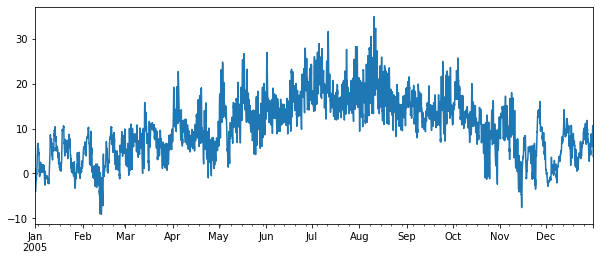

In [10]:
weather_data["Dry Bulb Temperature"].plot(figsize=(10,4))

In [11]:
Wdata_monthly = weather_data.resample('M').mean().round(1)
Wdata_monthly.insert(0, 'Month', Wdata_monthly.index.month)
Wdata_monthly['Month'] = pd.to_datetime(Wdata_monthly['Month'], format='%m').dt.month_name().str.slice(stop=3)
Wdata_monthly.set_index('Month')

Wdata_monthly

,Month,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Pressure,Extraterrestrial Horizontal Radiation,Extraterrestrial Direct Normal Radiation,Horizontal Infrared Radiation Intensity from Sky,Global Horizontal Radiation,Direct Normal Radiation,...,Opaque Sky Cover,Visibility,Ceiling Height,Present Weather Observation,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snow,Albedo,Liquid Precipitation Depth
2005-01-31,Jan,3.1,0.7,84.7,100152.2,100.0,1413.2,278.4,27.5,22.0,...,5.2,10.8,6753.8,6.0,0.0,0.1,1.6,88.0,0.0,0.0
2005-02-28,Feb,3.2,1.1,86.2,101058.3,163.2,1401.9,280.8,51.7,41.3,...,5.4,11.2,7203.7,6.0,0.0,0.1,2.8,88.0,0.0,0.0
2005-03-31,Mar,6.4,3.8,83.5,101026.2,258.6,1381.6,294.9,80.5,42.4,...,5.1,11.0,8121.3,6.6,0.0,0.2,2.0,88.0,0.0,0.0
2005-04-30,Apr,8.9,4.7,76.2,100523.5,362.0,1357.5,302.2,133.0,68.4,...,4.0,14.3,10069.6,7.2,0.0,0.2,2.0,88.0,0.0,0.0
2005-05-31,May,12.9,8.6,76.6,100865.7,442.8,1336.6,322.3,180.6,90.7,...,3.4,17.7,11751.5,7.6,0.0,0.2,2.0,88.0,0.0,0.0
2005-06-30,Jun,15.6,10.7,74.7,100692.2,480.1,1324.1,342.0,181.0,66.3,...,4.9,14.5,8256.2,7.4,0.0,0.2,2.0,88.0,0.0,0.0
2005-07-31,Jul,18.4,14.1,77.4,100926.1,462.5,1322.5,354.4,196.0,113.4,...,3.6,13.6,11088.6,7.5,0.0,0.2,2.0,88.0,0.0,0.0
2005-08-31,Aug,17.4,12.4,75.0,101162.4,395.5,1332.7,346.2,168.2,94.3,...,3.2,15.8,12355.3,7.8,0.0,0.2,2.0,88.0,0.0,0.0
2005-09-30,Sep,14.5,11.0,81.0,100780.0,300.2,1351.9,333.2,108.9,63.3,...,3.8,14.4,10494.9,7.3,0.0,0.2,2.0,88.0,0.0,0.0
2005-10-31,Oct,10.9,7.4,80.2,101396.4,199.1,1375.8,314.8,70.3,47.2,...,4.0,13.6,11163.7,7.2,0.0,0.2,2.0,88.0,0.0,0.0


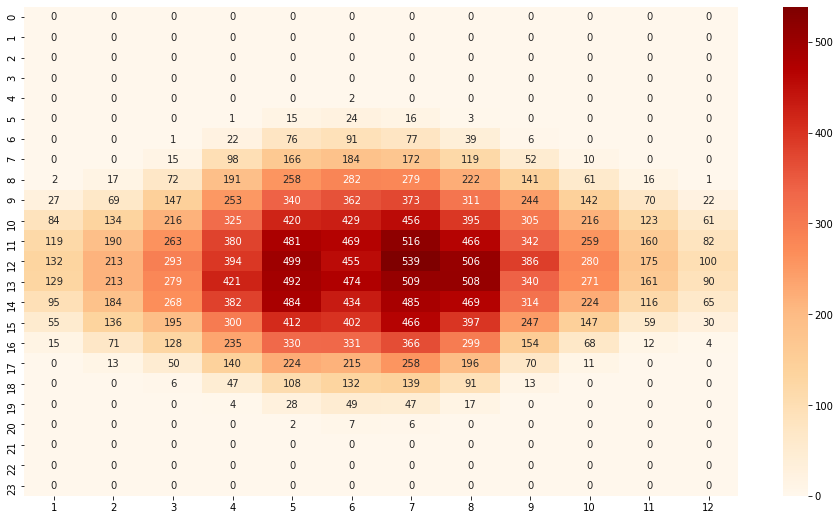

In [12]:
fig, ax = plt.subplots()

sns.heatmap(weather_data.groupby([weather_data.index.hour, weather_data.index.month]).mean()['Global Horizontal Radiation'].unstack(),
            ax=ax, annot=True, fmt=".0f", cmap='OrRd')

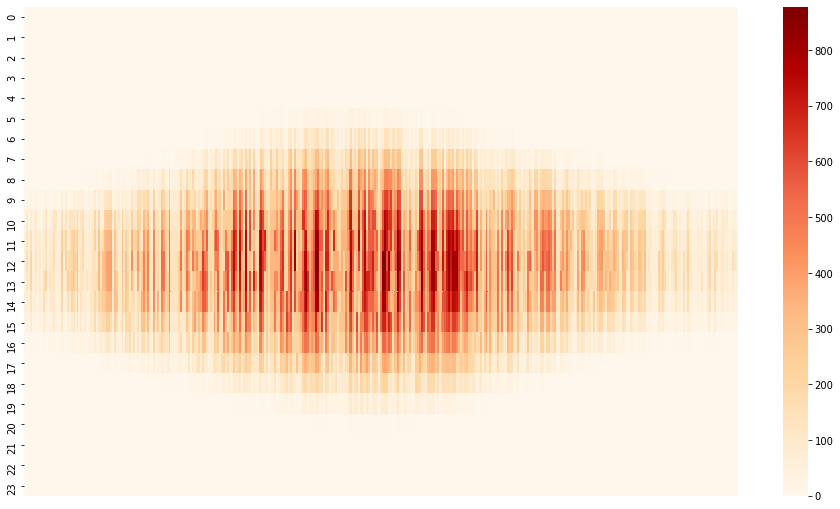

In [13]:
fig, ax = plt.subplots()

sns.heatmap(weather_data.groupby([weather_data.index.hour, weather_data.index.dayofyear]).sum()['Global Horizontal Radiation'].unstack(),
            ax=ax, xticklabels = False, annot=False, cmap='OrRd')

In [14]:
weather_data.groupby([weather_data.index.hour, weather_data.index.month]).mean()['Global Horizontal Radiation'].unstack().astype(int)

,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,1,15,24,16,3,0,0,0,0
6,0,0,0,21,76,91,77,38,5,0,0,0
7,0,0,14,97,165,184,171,118,51,10,0,0
8,2,16,71,190,258,282,279,221,141,60,16,1
9,27,68,146,252,339,361,373,310,243,141,69,21


# 2. BEM Results

In [15]:
# Absolute path to sql file
path = os.path.join(ROOT_DIR, r'OS\Office_BXL\run\eplusout.sql')
abs_sql_path = os.path.abspath(path)
abs_sql_path

'C:\\Users\\souvi\\Documents\\These\\80_Calculations\\03_BEM\\E+_Office_Repo\\OS\\Office_BXL\\run\\eplusout.sql'

In [16]:
# Creating a read-only URI
sql_uri = '{}?mode=ro'.format(pathlib.Path(abs_sql_path).as_uri())

In [ ]:
# Checking simulation info
query = 'SELECT EnergyPlusVersion FROM Simulations'
with sqlite3.connect(sql_uri, uri=True) as con:
    cursor = con.cursor()
    r = cursor.execute(query).fetchone()
    if r:
        simulation_info = r[0]
    else:
        msg = ("Cannot find the EnergyPlusVersion in the SQL file. "
               "Please inspect query used:\n{}".format(query))
        raise ValueError(msg)

print(simulation_info)

In [ ]:
# Environment info
with sqlite3.connect(sql_uri, uri=True) as con:
    df_env = pd.read_sql('SELECT * FROM EnvironmentPeriods', con=con)
df_env

## a. Unmet Hours

In [ ]:
def color_maxunmet_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if 300 > val > 0:
        color = 'blue' 
    elif val > 300:
        color = 'red'
    else:
        color = 'black'
    return 'color: %s' % color

In [ ]:
query = """SELECT RowName, ColumnName, Units, Value FROM TabularDataWithStrings
    WHERE ReportName = 'SystemSummary'
    AND ReportForString = 'Entire Facility'
    AND TableName = 'Time Setpoint Not Met'
    """

with sqlite3.connect(sql_uri, uri=True) as con:
    df_unmet = pd.read_sql(query, con=con)
        
    # Convert Value to Float
    df_unmet['Value'] = pd.to_numeric(df_unmet['Value'])
    
    df_unmet = df_unmet.pivot(index = 'RowName',
                              columns = 'ColumnName',
                              values = 'Value')

    df_unmet.columns.names = ['Time Setpoint Not Met (hr)']

    # Move 'Facility' as last row (Should always be in the index...)
    if 'Facility' in df_unmet.index:
        df_unmet = df_unmet.loc[[x for x
                                 in df_unmet.index
                                 if x != 'Facility'] + ['Facility']]
        
    df_unmet = df_unmet[~df_unmet.index.str.contains('PLENUM')]
    df_unmet = df_unmet[~df_unmet.index.str.contains('BASEMENT')]
    
    df_unmet = df_unmet.style.applymap(color_maxunmet_red)


df_unmet

In [ ]:
query = """SELECT EnvironmentPeriodIndex, Month, Day, Hour, Minute,
    ReportingFrequency, KeyValue, Name, Units, Value
    FROM ReportVariableWithTime
    WHERE ReportingFrequency = 'Hourly'
    AND Name = 'Lights Electric Energy'
    """

with sqlite3.connect(sql_uri, uri=True) as con:
    df_lights = pd.read_sql(query, con=con)
    
    df_lights = df_lights.pivot_table(index = ['Month', 'Day', 'Hour'],
                                columns = 'KeyValue',
                                values = 'Value')
    
    df_lights.columns.names = ['Lights Electric Energy (J)']
    
    df_lights.index = pd.date_range(start='2005-01-01 00:00', periods=8760, freq='1H')
    
df_lights    

In [ ]:
df_lights.columns.tolist()

In [ ]:
df_lights['Top Floor'] = (df_lights['TOP_CORE_TZ LIGHTS 2'] 
                          + df_lights['TOP_DATACENTER_TZ LIGHTS 3']
                          + df_lights['TOP_OFFICES_E_TZ LIGHTS 5']
                          + df_lights['TOP_OFFICES_N_TZ LIGHTS 6']
                          + df_lights['TOP_OFFICES_S_TZ LIGHTS 5']
                          + df_lights['TOP_OFFICES_W_TZ LIGHTS 5']
                         )

df_lights['Mid Floor'] = (df_lights['MID_CORE_TZ LIGHTS 2'] 
                          + df_lights['MID_DATACENTER_TZ LIGHTS 3']
                          + df_lights['MID_OFFICES_E_TZ LIGHTS 5']
                          + df_lights['MID_OFFICES_N_TZ LIGHTS 6']
                          + df_lights['MID_OFFICES_S_TZ LIGHTS 5']
                          + df_lights['MID_OFFICES_W_TZ LIGHTS 5']
                         )

df_lights['Ground Floor'] = (df_lights['GROUNDFLOOR_CORE_TZ LIGHTS 2'] 
                          + df_lights['GROUNDFLOOR_DATACENTER_TZ LIGHTS 3']
                          + df_lights['GROUNDFLOOR_HALL_S_TZ LIGHTS 4']
                          + df_lights['GROUNDFLOOR_OFFICES_E_TZ LIGHTS 5']
                          + df_lights['GROUNDFLOOR_OFFICES_N_TZ LIGHTS 6']
                          + df_lights['GROUNDFLOOR_OFFICES_W_TZ LIGHTS 5']
                         )

df_lightsperfloor = df_lights[['Ground Floor', 'Mid Floor', 'Top Floor']]
df_lightsperfloor.truncate(before='2005-07-08', after='2005-07-15').plot(subplots=True)

df_lightsperfloor

In [ ]:
df_lightsperfloor.resample('M').sum().plot(kind='bar')